In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('../')

# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


device(type='cuda')

In [2]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, df, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=df['train/loss'].sum(),
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_reward'] for res in self.eval_results[n//2:]])
			
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

In [9]:
from minigrid.wrappers import FlatObsWrapper, ImgObsWrapper

env = ImgObsWrapper(DoorKeyEnvSmall()) # wrap the environment to only give the vision data

# todo is this number of trajectories enough?
# todo should the reward scale be 1?
# todo make sure max_steps is not too much. we don't want the context length to be too big
traj_dataset = DoorKeyDataset(env, n_trajectories=2000, reward_scale=1)

collecting trajectories:   0%|          | 0/2000 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 400
reward_scale: 1
return min=0.0, max=0.65575 mean=0.0009693750000000001
gamma: 1


(array([3., 0., 0., 0., 2., 0., 0., 0., 0., 1.]),
 array([0.1585  , 0.208225, 0.25795 , 0.307675, 0.3574  , 0.407125,
        0.45685 , 0.506575, 0.5563  , 0.606025, 0.65575 ]),
 <BarContainer object of 10 artists>)

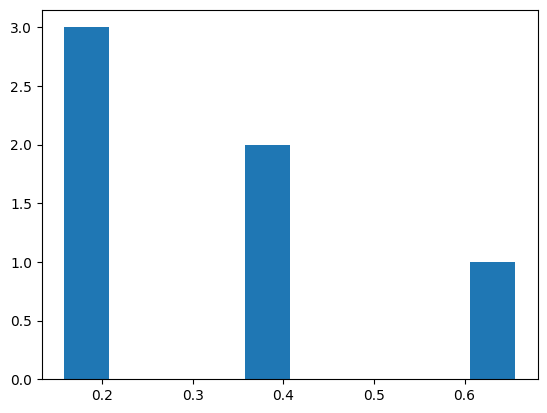

In [15]:
ds_rewards = np.array([traj_dataset.reward_convertor.from_feature_space(traj.returns[0]) for traj in traj_dataset])
ds_pos_rewards = np.array([ret for ret in ds_rewards if ret > 0])
plt.hist(ds_pos_rewards)

In [10]:
# todo rtg_range_check and rtg_main are used for plotting and monitoring
# todo is the rtg_range_check correct?
config = TrainConfig(max_eval_ep_len=20, context_len=64, rtg_range_check=(0, 5), rtg_main=5)

experiment_name = 'first-small-door-key-experiment'

model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

trainer = TrainerDT(name=experiment_name, model=model,
					optimizer=optimizer, loss_fn=loss_fn,
					dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
					device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

trainer.register_callback(callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

number of parameters 1159579


In [11]:
report = trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  0.0
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-09-18-50-18_best.pt
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-09-18-50-18.pt
time elapsed: 0:00:03
num of updates: 100
loss: 32.69773
eval avg reward: 0.00000
best score: -inf
eval_avg_ep_len 20.00000
grad_norm 0.18322
lr 0.00001
achieved average reward:  0.0
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-09-18-50-18_best.pt
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_first-small-door-key-experiment_model_24-05-09-18-50-18.pt
time elapsed: 0:01:21
num of updates: 200
loss: 23.84351
eval avg reward: 0.00000
best score: 0.00000
eval_avg_ep_len 20.00000
grad_norm 0.11460
lr 0.00002
a

KeyboardInterrupt: 

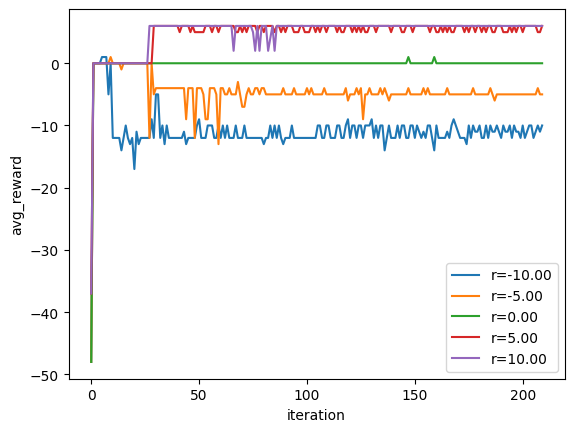

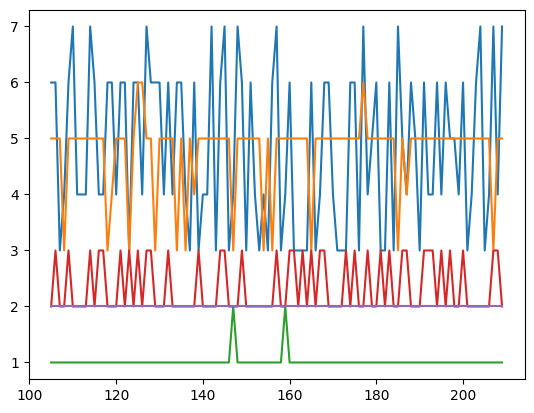

In [28]:
callback.plot_eval_results()

<Axes: >

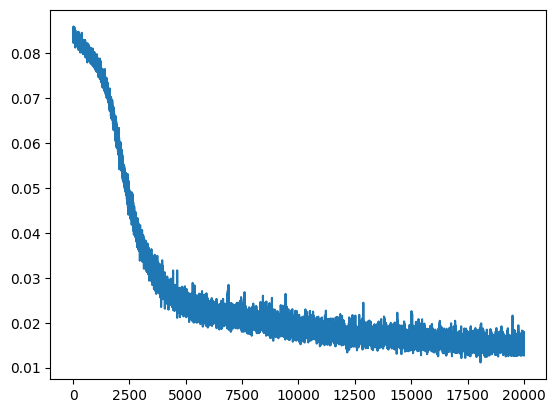

In [48]:
report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()